# Floodplain Train and Test

**Timm Nawrocki**  
Alaska Center for Conservation Science  
2019-04-19

In [1]:
# -*- coding: utf-8 -*-
# ---------------------------------------------------------------------------
# Floodplain Train and Test
# Author: Timm Nawrocki, Alaska Center for Conservation Science
# Created on: 2019-04-19
# Usage: Must be executed as a Jupyter Notebook in an Anaconda 3 installation.
# Description: "Floodplain Train and Test" trains a classifier to predict floodplain presence and absence. All model performance metrics are calculated on independent test partitions.
# ---------------------------------------------------------------------------

## 1. Initialize Environment

In [2]:
# Import packages
import datetime
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import os
import seaborn as sns
import time
# Import modules for model selection, cross validation, random forest, and performance from Scikit Learn
from sklearn.utils import shuffle
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

# Set root directory
drive = 'E:/'
root_directory = os.path.join(drive, 'ACCS_Work/Projects/VegetationEcology/BristolBay_Vegetation/Project_GIS/Data_Output')

# Create a plots folder if it does not exists
plots_folder = os.path.join(root_directory, 'model_floodplain/plots')
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

# Define input dataset
sample_file = os.path.join(root_directory, 'sample_floodplain/FloodplainSample_NuyakukAleknagik.csv')

# Define output files
output_classifier = os.path.join(root_directory, 'model_floodplain/classifier_floodplain.joblib')
output_csv = os.path.join(root_directory, 'model_floodplain/output_test.csv')
output_report = os.path.join(root_directory, 'model_floodplain/report_floodplain.html')
threshold_file = os.path.join(root_directory, 'model_floodplain/threshold.txt')
metrics_file = os.path.join(root_directory, 'model_floodplain/metrics.csv')

# Define plots
classifier_feature_file = os.path.join(plots_folder, "classifier_feature_elimination.png")
importance_classifier = os.path.join(plots_folder, "importance_classifier.png")
variable_correlation = os.path.join(plots_folder, "variable_correlation.png")

In [3]:
# Define variable sets
predictor_env = ['aspect', 'compoundTopographic', 'dateFreeze', 'dateThaw', 'elevation', 'exposure', 'growingSeason', 'heatLoad', 'moisture', 'precipitation', 'roughness', 'slope', 'summerWarmth', 'surfaceArea', 'surfaceRelief']
predictor_may = ['X05May_1_ultraBlue', 'X05May_2_blue', 'X05May_3_green', 'X05May_4_red', 'X05May_5_redEdge1', 'X05May_6_redEdge2', 'X05May_7_redEdge3', 'X05May_8_nearInfrared', 'X05May_8a_redEdge4', 'X05May_11_shortInfrared1', 'X05May_12_shortInfrared2', 'X05May_nbr', 'X05May_ndmi', 'X05May_ndsi', 'X05May_ndvi', 'X05May_ndwi']
predictor_jun = ['X06June_1_ultraBlue', 'X06June_2_blue', 'X06June_3_green', 'X06June_4_red', 'X06June_5_redEdge1', 'X06June_6_redEdge2', 'X06June_7_redEdge3', 'X06June_8_nearInfrared', 'X06June_8a_redEdge4', 'X06June_11_shortInfrared1', 'X06June_12_shortInfrared2', 'X06June_nbr', 'X06June_ndmi', 'X06June_ndsi', 'X06June_ndvi', 'X06June_ndwi']
predictor_jul = ['X07July_1_ultraBlue', 'X07July_2_blue', 'X07July_3_green', 'X07July_4_red', 'X07July_5_redEdge1', 'X07July_6_redEdge2', 'X07July_7_redEdge3', 'X07July_8_nearInfrared', 'X07July_8a_redEdge4', 'X07July_11_shortInfrared1', 'X07July_12_shortInfrared2', 'X07July_nbr', 'X07July_ndmi', 'X07July_ndsi', 'X07July_ndvi', 'X07July_ndwi']
predictor_aug = ['X08August_1_ultraBlue', 'X08August_2_blue', 'X08August_3_green', 'X08August_4_red', 'X08August_5_redEdge1', 'X08August_6_redEdge2', 'X08August_7_redEdge3', 'X08August_8_nearInfrared', 'X08August_8a_redEdge4', 'X08August_11_shortInfrared1', 'X08August_12_shortInfrared2', 'X08August_nbr', 'X08August_ndmi', 'X08August_ndsi', 'X08August_ndvi', 'X08August_ndwi']
predictor_sep = ['X09September_1_ultraBlue', 'X09September_2_blue', 'X09September_3_green', 'X09September_4_red', 'X09September_5_redEdge1', 'X09September_6_redEdge2', 'X09September_7_redEdge3', 'X09September_8_nearInfrared', 'X09September_8a_redEdge4', 'X09September_11_shortInfrared1', 'X09September_12_shortInfrared2', 'X09September_nbr', 'X09September_ndmi', 'X09September_ndsi', 'X09September_ndvi', 'X09September_ndwi']
predictor_oct = ['X10October_1_ultraBlue', 'X10October_2_blue', 'X10October_3_green', 'X10October_4_red', 'X10October_5_redEdge1', 'X10October_6_redEdge2', 'X10October_7_redEdge3', 'X10October_8_nearInfrared', 'X10October_8a_redEdge4', 'X10October_11_shortInfrared1', 'X10October_12_shortInfrared2', 'X10October_nbr', 'X10October_ndmi', 'X10October_ndsi', 'X10October_ndvi', 'X10October_ndwi']
predictor_all = predictor_env + predictor_may + predictor_jun + predictor_jul + predictor_aug + predictor_sep + predictor_oct
iteration = ['iteration']
response = ['FLOOD']
predict = ['presence']
all_variables = predictor_all + response
output_variables = iteration + response + predict

In [4]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plot.rcParams["figure.figsize"] = fig_size
plot.style.use('grayscale')

## 2. Define Model Functions

In [5]:
# Create a function to create the train and test partitions
def partitionData(inData, all_variables, predictors, response, strata):
    # Create train and test splits
    X = inData[all_variables]
    y = inData[response[0]]
    stratify = inData[strata[0]]
    all_train, all_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            test_size = 0.3,
                                                            train_size = 0.7,
                                                            random_state = None,
                                                            shuffle = True,
                                                            stratify = stratify)
    # Reset the index on the train and test splits
    all_train = all_train.reset_index()
    all_test = all_test.reset_index()
    return all_train, all_test

In [6]:
# Create a function to train a classifier on the train X and y and predict the test X
def trainPredictClassifier(train, test, predictors, response, classifier):
    # Define X and y
    X_train = train[predictors]
    y_train = train[response[0]]
    X_test = test[predictors]
    # Fit a classifier to the train X and y
    classifier.fit(X_train, y_train)
    # Use the classifier to predict class probabilities
    prediction = classifier.predict_proba(X_test)
    # Concatenate predicted values to test data frame
    test = pd.concat([test, pd.DataFrame(prediction)], axis=1)
    test = test.rename(index=int, columns={0: 'absence', 1: 'presence'})
    # Return the predictions
    return test

In [7]:
# Define a function to calculate performance metrics based on a specified threshold value
def testPresenceThreshold(predict_probability, threshold, y_test):
    # Create an empty array of zeroes that matches the length of the probability predictions
    predict_thresholded = np.zeros(predict_probability.shape)
    # Set values for all probabilities greater than or equal to the threshold equal to 1
    predict_thresholded[predict_probability >= threshold] = 1
    # Determine error rates
    confusion_test = confusion_matrix(y_test, predict_thresholded)
    true_negative = confusion_test[0,0]
    false_negative = confusion_test[1,0]
    true_positive = confusion_test[1,1]
    false_positive = confusion_test[0,1]
    # Calculate sensitivity and specificity
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    # Calculate AUC score
    auc = roc_auc_score(y_test, predict_probability)
    # Calculate overall accuracy
    accuracy = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)
    # Return the thresholded probabilities and the performance metrics
    return (sensitivity, specificity, auc, accuracy)

In [8]:
# Create a function to determine a presence threshold
def determineOptimalThreshold(predict_probability, y_test):
    # Iterate through numbers between 0 and 1000 to output a list of sensitivity and specificity values per threshold number
    i = 1
    sensitivity_list = []
    specificity_list = []
    while i < 1001:
        threshold = i/1000
        sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        i = i + 1
    # Calculate a list of absolute value difference between sensitivity and specificity and find the optimal threshold
    difference_list = [np.absolute(a - b) for a, b in zip(sensitivity_list, specificity_list)]
    value, threshold = min((value, threshold) for (threshold, value) in enumerate(difference_list))
    threshold = threshold/1000
    # Calculate the performance of the optimal threshold
    sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
    # Return the optimal threshold and the performance metrics of the optimal threshold
    return threshold, sensitivity, specificity, auc, accuracy

In [9]:
# Plot the results of the recursive feature eliminator for the classifier
def plotFeatureElimination(feature_eliminator, y_label, feature_plot_file):
    feature_plot = plot.figure()
    fig_size = plot.rcParams["figure.figsize"]
    fig_size[0] = 8
    fig_size[1] = 6
    plot.rcParams["figure.figsize"] = fig_size
    plot.xlabel("Number of features selected")
    plot.ylabel(y_label)
    plot.plot(range(1, len(feature_eliminator.grid_scores_) + 1), feature_eliminator.grid_scores_)
    plot.show()
    feature_plot.savefig(feature_plot_file, bbox_inches="tight", dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [10]:
# Define a function to plot Pearson correlation of predictor variables
def plotVariableCorrelation(X_train, outFile):
    # Calculate Pearson correlation coefficient between the predictor variables, where -1 is perfect negative correlation and 1 is perfect positive correlation
    correlation = X_train.astype('float64').corr()
    # Generate a mask for the upper triangle of plot
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plot.subplots(figsize=(20, 18))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    correlation_plot = sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})
    correlation_figure = correlation_plot.get_figure()
    correlation_figure.savefig(outFile, bbox_inches='tight', dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [11]:
# Define a function to plot variable importances
def plotVariableImportances(inModel, X_train, outVariableFile):
    # Get numerical feature importances
    importances = list(inModel.feature_importances_)
    # List of tuples with variable and importance
    feature_list = list(X_train.columns)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Initialize the plot and set figure size
    variable_figure = plot.figure()
    fig_size = plot.rcParams["figure.figsize"]
    fig_size[0] = 18
    fig_size[1] = 6
    plot.rcParams["figure.figsize"] = fig_size
    # Create list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart of the variable importances
    plot.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plot.xticks(x_values, feature_list, rotation='vertical')
    # Axis labels and title
    plot.ylabel('Importance'); plot.xlabel('Variable'); plot.title('Variable Importances');
    # Export
    variable_figure.savefig(outVariableFile, bbox_inches="tight", dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [12]:
# Create a function to train and export a classifier
def trainExportClassifier(input_data, predictors, response, classifier, outModel, outImportance):
    # Define the predictor labels (X) and the response label (y) in the input dataframe
    X = input_data[predictors]
    y = input_data[response[0]]
    # Fit a classifier to the input dataset
    classifier.fit(X, y)
    # Save classifier to an external file
    joblib.dump(classifier, outModel)
    # Export a variable importance plot
    plotVariableImportances(classifier, X, outImportance)

## 3. Conduct Analyses

### 3.1 Process input data

In [13]:
# Start timing function execution
start = time.time()
# Create data frame of input data
sample_data = pd.read_csv(sample_file)
# Remove rows with missing values
sample_data = sample_data.dropna(axis=0, how='any')
# Convert values to floats
sample_data[predictor_all] = sample_data[predictor_all].astype(float)
# Shuffle data
sample_data = shuffle(sample_data)
# Define X and y
X = sample_data[predictor_all]
y = sample_data[response[0]]
# End timing
end = time.time()
elapsed = int(end - start)
success_time = datetime.datetime.now()
# Report process success
out_process = 'Succeeded at {0} (Elapsed time: {1})'.format(success_time.strftime("%Y-%m-%d %H:%M"),
                                                            datetime.timedelta(seconds=elapsed))
print(out_process)

Succeeded at 2019-04-20 12:11 (Elapsed time: 0:00:00)


In [14]:
# Define classifier
classifier = RandomForestClassifier(n_estimators = 5000,
                                    criterion = 'entropy',
                                    max_features = 'log2',
                                    bootstrap = True,
                                    oob_score = True,
                                    n_jobs = 4,
                                    class_weight = 'balanced')

### 3.2 Recursively Eliminate Features

Selecting optimal feature set...
Optimal number of features : 45


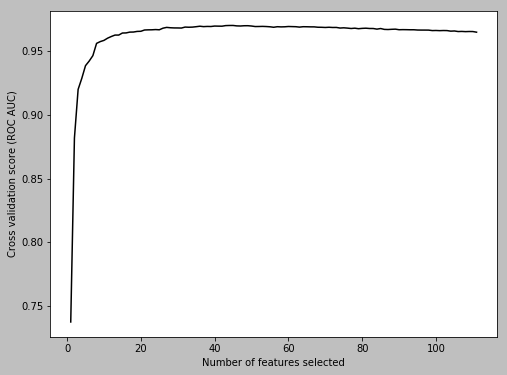

Succeeded at 2019-04-20 14:34 (Elapsed time: 2:22:10)


In [15]:
# Start timing function execution
start = time.time()
print("Selecting optimal feature set...")
# Shuffle X and y data
X, y = shuffle(X, y)
# Define a cross validation split method
cv_splits_classifier = ShuffleSplit(n_splits=10, test_size=0.3, train_size=0.7, random_state=None)
# Define a recursive feature eliminator for the classifier using shuffled cross validation
recursive_eliminator_classifier = RFECV(estimator=classifier, step=1, cv=cv_splits_classifier, scoring='roc_auc')
# Fit the recursive feature eliminator
recursive_eliminator_classifier.fit(X, y)
# Print optimal number of features for the classifier
print("Optimal number of features : %d" % recursive_eliminator_classifier.n_features_)
# Plot the results of the recursive feature eliminator for the classifier
y_label = "Cross validation score (ROC AUC)"
plotFeatureElimination(recursive_eliminator_classifier, y_label, classifier_feature_file)
# Select the optimal subset of features for the classifier
classifier_features = pd.DataFrame({'predictor': list(X.columns),
                                    'select': recursive_eliminator_classifier.ranking_.tolist()})
classifier_features = classifier_features.loc[classifier_features['select'] == 1]
classifier_features = classifier_features['predictor'].tolist()
# End timing
end = time.time()
elapsed = int(end - start)
success_time = datetime.datetime.now()
# Report process success
out_process = 'Succeeded at {0} (Elapsed time: {1})'.format(success_time.strftime("%Y-%m-%d %H:%M"),
                                                            datetime.timedelta(seconds=elapsed))
print(out_process)

### 3.3 Train and Test Iterations (n=100)

In [18]:
# Start timing function execution
start = time.time()
# Create empty lists to store threshold and performance metrics
threshold_list = []
sensitivity_list = []
specificity_list = []
auc_list = []
accuracy_list = []
# Create an empty data frame to store the test results
output_test = pd.DataFrame(columns = output_variables)
i = 1
while i < 101:
    # Split the data into train and test partitions
    train, test = partitionData(sample_data, all_variables, predictor_all, response, response)
    # Add the iteration count to the test data
    test['iteration'] = i
    # Train and predict a classifier
    test = trainPredictClassifier(train, test, classifier_features, response, classifier)
    # Calculate the optimal threshold and performance of the presence-absence classification
    threshold, sensitivity, specificity, auc, accuracy = determineOptimalThreshold(test[predict[0]], test[response[0]])
    # Add threshold and performance metrics to list
    threshold_list.append(threshold)
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)
    auc_list.append(auc)
    accuracy_list.append(accuracy)
    # Add the test results to output data frame
    output_test = output_test.append(test, ignore_index=True, sort=True)
    print('Model train-test iteration ' + str(i) + ' out of 100 completed...')
    # Increase the counter by 1
    i = i+1
# End timing
end = time.time()
elapsed = int(end - start)
success_time = datetime.datetime.now()
# Report process success
out_process = 'Succeeded at {0} (Elapsed time: {1})'.format(success_time.strftime("%Y-%m-%d %H:%M"),
                                                            datetime.timedelta(seconds=elapsed))
print(out_process)

Model train-test iteration 1 out of 100 completed...
Model train-test iteration 2 out of 100 completed...
Model train-test iteration 3 out of 100 completed...
Model train-test iteration 4 out of 100 completed...
Model train-test iteration 5 out of 100 completed...
Model train-test iteration 6 out of 100 completed...
Model train-test iteration 7 out of 100 completed...
Model train-test iteration 8 out of 100 completed...
Model train-test iteration 9 out of 100 completed...
Model train-test iteration 10 out of 100 completed...
Model train-test iteration 11 out of 100 completed...
Model train-test iteration 12 out of 100 completed...
Model train-test iteration 13 out of 100 completed...
Model train-test iteration 14 out of 100 completed...
Model train-test iteration 15 out of 100 completed...
Model train-test iteration 16 out of 100 completed...
Model train-test iteration 17 out of 100 completed...
Model train-test iteration 18 out of 100 completed...
Model train-test iteration 19 out of 

## 5.4 Export Results

In [19]:
# Export test results to csv
output_test.to_csv(output_csv, header=True, index=False, sep=',', encoding='utf-8')

In [20]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

In [21]:
# Export a Pearson Correlation plot for the predictor variables
plotVariableCorrelation(sample_data[predictor_all], variable_correlation)

In [22]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 6
plot.rcParams["figure.figsize"] = fig_size

In [23]:
# Train and export a final classifier using the full input data
trainExportClassifier(sample_data,
                      classifier_features,
                      response,
                      classifier,
                      output_classifier,
                      importance_classifier)

In [24]:
# Calculate mean for threshold and all performance metrics
threshold_mean = np.mean(threshold_list)
sensitivity_mean = np.mean(sensitivity_list)
specificity_mean = np.mean(specificity_list)
auc_mean = np.mean(auc_list)
accuracy_mean = np.mean(accuracy_list)
# Calculate standard deviation for threshold and all performance metrics
threshold_sd = np.std(threshold_list)
sensitivity_sd = np.std(sensitivity_list)
specificity_sd = np.std(specificity_list)
auc_sd = np.std(auc_list)
accuracy_sd = np.std(accuracy_list)

In [25]:
# Export threshold and performance metrics as a table
metrics_dataframe = pd.DataFrame({'threshold':threshold_list,
                                  'sensitivity':sensitivity_list,
                                  'specificity':specificity_list,
                                  'auc':auc_list,
                                  'accuracy':accuracy_list})
metrics_dataframe.to_csv(metrics_file, header=True, index=False, sep=',', encoding='utf-8')

In [26]:
# Write a text file to store the presence-absence conversion threshold
file = open(threshold_file, 'w')
file.write(str(round(threshold_mean, 5)))
file.close()

In [27]:
# Write html text file
output_text = os.path.splitext(output_report)[0] + ".txt"
text_file = open(output_text, "w")
text_file.write("<html>\n")
text_file.write("<head>\n")
text_file.write("<meta http-equiv=\"pragma\" content=\"no-cache\">\n")
text_file.write("<meta http-equiv=\"Expires\" content=\"-1\">\n")
text_file.write("</head>\n")
text_file.write("<body>\n")
text_file.write("<div style=\"width:90%;max-width:1000px;margin-left:auto;margin-right:auto\">\n")
text_file.write("<h1 style=\"text-align:center;\">Distribution model performance for Floodplains</h1>\n")
text_file.write("<br>" + "\n")
text_file.write("<h2>Predicted Distribution Pattern</h2>\n")
text_file.write("<p><i>Prediction step has not yet been performed. No output to display.</i></p>\n")
text_file.write("<h2>Recursive Feature Elimination</h2>\n")
text_file.write("<p>A total of 96 features were prepared for the modeling process. Uninformative features are a potential source of noise in the models and retaining the uninformative features could result in reduced predictive performance. We selected the best performing set of features by recursive feature elimination based on the cross validation of ROC AUC for classification.</p>\n")
text_file.write("<p>The optimal number of variables for the classifier was " + str(recursive_eliminator_classifier.n_features_) + ".</p>\n")
text_file.write("<a target='_blank' href='plots\\classifier_feature_elimination.png'><img style='display:inline-block;max-width:720px;width:100%;' src='plots\\classifier_feature_elimination.png'></a>\n")
text_file.write("<h2>Model Performance</h2>\n")
text_file.write("<p>Model performance was measured by area under the receiver operating characteristic curve (AUC) and overall accuracy, where specificity and sensitivity are as close to equal as possible (i.e, the model performs equally well at predicting absences and presences). All performance results are reported as the mean and standard deviation of the independent test predictions from 100 train-test splits. For each split, 30% of the data was withheld from model training and used as an independent test partition.</p>\n")
text_file.write("<h3>Overall Performance</h3>\n")
text_file.write("<p>AUC = " + str(np.round(auc_mean, 2)) + " +/- " + str(np.round(auc_sd, 2)) +"</p>\n")
text_file.write("<p>Presence-Absence Accuracy = " + str(np.round(accuracy_mean, 2)) + " +/- " + str(np.round(accuracy_sd, 2)) +"</p>\n")
text_file.write("<h3>Classifier Importances</h3>\n")
text_file.write("<p>The Variable Importance plot for the classifier is shown below:</p>\n")
text_file.write("<a target='_blank' href='plots\\importance_classifier.png'><img style='display:inline-block;max-width:1000px;width:100%;' src='plots\\importance_classifier.png'></a>\n")
text_file.write(r"<h2>Variable Correlation</h2>" + "\n")
text_file.write("<p>The plot below explores variable correlation. No attempt was made to remove highly correlated variables (shown in the plot dark blue).</p>\n")
text_file.write("<a target='_blank' href='plots\\variable_correlation.png'><img style='display:inline-block;width:100%;' src='plots\\variable_correlation.png'></a>\n")
text_file.write("</div>\n")
text_file.write("</body>\n")
text_file.write("</html>\n")
text_file.close()

In [28]:
# Rename HTML Text to HTML
if os.path.exists(output_report) == True:
    os.remove(output_report)
os.rename(output_text, output_report)